# Density of States
This example is originally from [GPUMD](https://github.com/brucefan1983/GPUMD) and has been added here with minor changes only to demonstrate how to use [gpyumd](https://github.com/AlexGabourie/gpyumd).

## 1. Introduction
- In this example, we calculate the phonon (vibrational) density of states (DOS) of graphene at 300 K and zero pressure. The method is based on the velocity auto-correlation (VAC) function. The DOS is calculated as the Fourier transform of the VAC [[Dickey 1969]](https://doi.org/10.1103/PhysRev.188.1407).

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [gpyumd](https://github.com/AlexGabourie/gpyumd) package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase.build import graphene_nanoribbon
from gpyumd.load import load_dos, load_vac
from gpyumd.atoms import GpumdAtoms
from gpyumd.sim import Simulation
import gpyumd.keyword as kwd

## 2. Preparing the Inputs
- We use a sheet of graphene consisting of 8640 carbon atoms and use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).

### The  [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file

In [2]:
gnr = GpumdAtoms(graphene_nanoribbon(60, 36, type='armchair', sheet=True, vacuum=3.35/2, C_C=1.44))
gnr.euler_rotate(theta=90)
lx, lz, ly = gnr.cell.lengths()
gnr.cell = gnr.cell.new((lx, ly, lz))
gnr.center()
gnr.pbc = [True, True, False]
gnr.set_cutoff(2.1)
gnr.set_max_neighbors(3)
gnr.write_gpumd()
gnr

GpumdAtoms(symbols='C8640', pbc=[True, True, False], cell=[149.64918977395098, 155.52, 3.35])

- The first few lines of the [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file are:
```
8640 3 2.1 0 0 0
1 1 0 149.649 155.52 3.35
0 1.24708 0 0 12
0 0 0.72 0 12
0 0 2.16 0 12
0 1.24708 2.88 0 12
```

- Explanations for the first line:
  - The first number states that the number of particles is 8640.
  - The second number in this line, 3, is good for graphene described by the Tersoff potential because no atom can have more than 3 neighbor atoms at room temperature. Making this number larger only results in more memory usage. If this number is not large enough, GPUMD will give an error message and exit.
  - The next number, 2.1, means that the initial cutoff distance for the neighbor list construction is 2.1 A. Here, we only need to consider the first nearest neighbors. Any number larger than the first nearest neighbor distance and smaller than the second nearest neighbor distance is OK here. Note that we will also not update the neighbor list. There is no such need in this problem. 
  - The remaining three zeros in the first line mean:
    - the box is orthogonal;
    - the initial velocities are not contained in this file;
    - there are no grouping methods defined here.


 - Explanations for the second line:
   - The numbers 1 1 0 mean that the $x$ and $y$ (in-plane) directions are periodic and the $z$ direction is open (free).
   - The remaining three numbers are the box lengths in the three directions. The box length in a free direction is chosen based on some convention. This number will only affect the system volume.

- Starting from the third line, the numbers in the first column are all 0 here, which means that all the atoms are of type 0 (single atom-type system). The next three columns are the initial coordinates of the atoms. The last column gives the masses of the atoms. Here, we consider isotopically pure C-12 crystal, but this Jupyter notebook will generate an [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file using the average of the various isotopes of C. In some applications, one can consider mass disorder in a flexible way.

Note: We write the <code>xyz.in</code> file here for demonstration purposes, but the Simulation we are about to make also outputs the <code>xyz.in</code> file.

### The <code>run.in</code> file
The [gpyumd](https://github.com/AlexGabourie/gpyumd) package can be used to generate valid <code>run.in</code> input files as well as other necessary input files. It follows the definitions described in the [inputs and outputs](https://gpumd.zheyongfan.org/index.php/Main_Page#Inputs_and_outputs_for_GPUMD) documentation for <code>GPUMD</code>.

In [3]:
# Create an empty simulation to build our run.in file with
# Using the correct driver_directory is essential for potential path definitions.
dos_sim = Simulation(gnr, driver_directory='.')

In [4]:
# Programmatically define our density of states runs

# Equilibration run
header_comment = "Equilibration: establish a proper structure and temperature"
curr_run = dos_sim.add_run(number_of_steps=2e5, run_name='equilibration', run_header=header_comment)

pres = 0  # GPa
elast = 53.4059  # GPa
keywords = [
    kwd.Velocity(initial_temperature=300),
    kwd.EnsembleNPT.orthogonal(method='npt_ber', initial_temperature=300, 
                               final_temperature=300, thermostat_coupling=100, 
                               barostat_coupling=2000, p_xx=pres, p_yy=pres, p_zz=pres,
                               c_xx=elast, c_yy=elast, c_zz=elast),
    kwd.TimeStep(dt_in_fs=1),
    kwd.NeighborOff(),
    kwd.DumpThermo(100)
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [5]:
# Production run
header_comment = "Production: calculate the density of states"
curr_run = dos_sim.add_run(run_name='production', run_header=header_comment)

# Timestep is propagated from last run
keywords = [
    kwd.EnsembleNVE(),
    kwd.NeighborOff(),
    kwd.ComputeDOS(sample_interval=5, num_corr_steps=200, max_omega=400.0),
    kwd.RunKeyword(number_of_steps=2e5)  # Can add run here instead of during add_run fucntion
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [6]:
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='Graphene_Lindsay_2010_modified.txt', symbols=['C'], directory=potential_directory)
dos_sim.add_potential(tersoff_potential)

In [7]:
dos_sim.create_simulation(copy_potentials=True)

The <code>run.in</code> input file is given below:<br>
```
potential Graphene_Lindsay_2010_modified.txt 0

# Equilibration: establish a proper structure and temperature
velocity 300 
time_step 1 
ensemble npt_ber 300 300 100 0 0 0 53.4059 53.4059 53.4059 2000 
neighbor off 
dump_thermo 100 
run 200000 

# Production: calculate the density of states
ensemble nve 
neighbor off 
compute_dos 5 200 400.0 
run 200000 
```
 - The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

 - The second line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K. 

 - There are two runs:
   - The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage, where the NPT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Berendsen method) is used. The temperature is 300 K and the pressures are zero in all the directions. The coupling constants are 100 and 2000 time steps for the thermostat and the barostat (The elastic constant, or inverse compressibility parameter needed in the barostat is estimated to be 53.4059 GPa; this only needs to be correct up to the order of magnitude.), respectively. The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs. There are $2\times 10^5$ steps (200 ps) for this [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) and the thermodynamic quantities will be output every 1000 steps. 
   - The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword), where the NVE [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) is used. The line with [compute_dos](https://gpumd.zheyongfan.org/index.php/The_compute_dos_keyword) means that velocities will be recorded every 5 steps (5 fs) and 200 VAC data (the maximum correlation time is then about 1 ps) will be calculated. The last parameter in this line is the maximum angular frequency considered, $\omega_{\rm max} = 2\pi\nu_{\rm max} =400$ THz, which is large enough for graphene. The production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) lasts 200 ps.

## 3. Results and Discussion
### Computation Time
 - This simulation takes about 1.5 min when a Tesla K40 is used. 
 -  The speed of this simulation is about $4\times 10^7$ atom x step / second.

### Figure Properties

In [8]:
aw = 2
fs = 16
font = {'size'   : fs}
plt.rc('font', **font)
plt.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    ax_list = ax_list if isinstance(ax_list, list) else [ax_list]
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot DOS and VAC
 - The [dos.out](https://gpumd.zheyongfan.org/index.php/The_dos.out_output_file) and [mvac.out](https://gpumd.zheyongfan.org/index.php/The_mvac.out_output_file) output files are loaded and processed to create the following figure.

In [9]:
num_corr_steps = 200
dos = load_dos(num_dos_points=num_corr_steps)['run0']
vac = load_vac(num_corr_steps)['run0']
dos['DOSxyz'] = dos['DOSx']+dos['DOSy']+dos['DOSz']
vac['VACxyz'] = vac['VACx']+vac['VACy']+vac['VACz']
vac['VACxyz'] /= vac['VACxyz'].max() 
print('DOS:', list(dos.keys()))
print('VAC:', list(vac.keys()))

DOS: ['nu', 'DOSx', 'DOSy', 'DOSz', 'DOSxyz']
VAC: ['t', 'VACx', 'VACy', 'VACz', 'VACxyz']


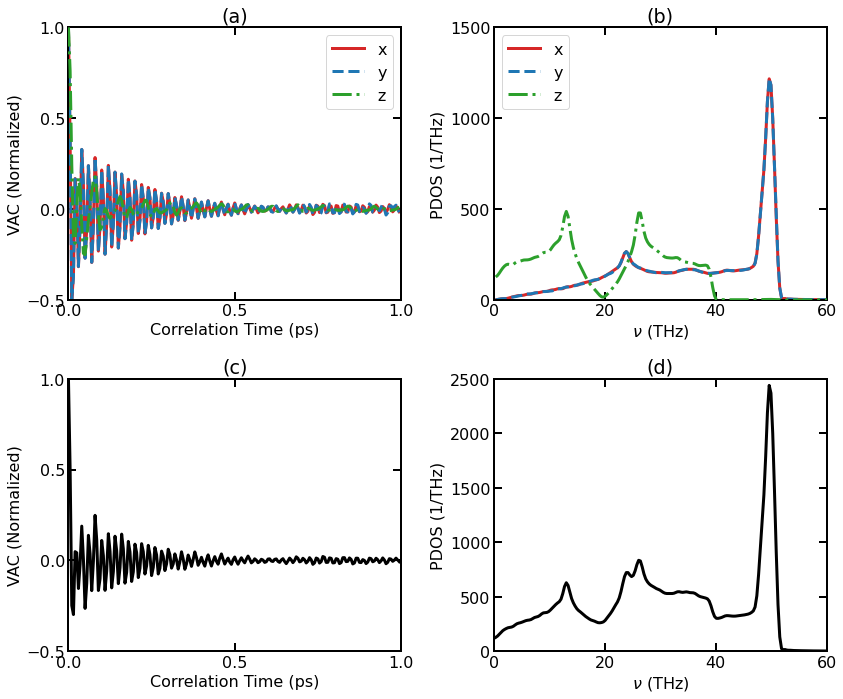

In [10]:
axes = list()
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
axes.append(plt.gca())
plt.plot(vac['t'], vac['VACx']/vac['VACx'].max(), color='C3',linewidth=3)
plt.plot(vac['t'], vac['VACy']/vac['VACy'].max(), color='C0', linestyle='--',linewidth=3)
plt.plot(vac['t'], vac['VACz']/vac['VACz'].max(), color='C2', linestyle='-.',zorder=100,linewidth=3)
plt.xlim([0,1])
plt.gca().set_xticks([0,0.5,1])
plt.ylim([-0.5, 1])
plt.gca().set_yticks([-0.5,0,0.5,1])
plt.ylabel('VAC (Normalized)')
plt.xlabel('Correlation Time (ps)')
plt.legend(['x','y', 'z'])
plt.title('(a)')

plt.subplot(2,2,2)
axes.append(plt.gca())
plt.plot(dos['nu'], dos['DOSx'], color='C3',linewidth=3)
plt.plot(dos['nu'], dos['DOSy'], color='C0', linestyle='--',linewidth=3)
plt.plot(dos['nu'], dos['DOSz'], color='C2', linestyle='-.',zorder=100, linewidth=3)
plt.xlim([0, 60])
plt.gca().set_xticks(range(0,61,20))
plt.ylim([0, 1500])
plt.gca().set_yticks(np.arange(0,1501,500))
plt.ylabel('PDOS (1/THz)')
plt.xlabel(r'$\nu$ (THz)')
plt.legend(['x','y', 'z'])
plt.title('(b)')

plt.subplot(2,2,3)
axes.append(plt.gca())
plt.plot(vac['t'], vac['VACxyz'], color='k',linewidth=3)
plt.xlim([0,1])
plt.gca().set_xticks([0,0.5,1])
plt.ylim([-0.5, 1])
plt.gca().set_yticks([-0.5,0,0.5,1])
plt.ylabel('VAC (Normalized)')
plt.xlabel('Correlation Time (ps)')
plt.title('(c)')

plt.subplot(2,2,4)
axes.append(plt.gca())
plt.plot(dos['nu'], dos['DOSxyz'], color='k',linewidth=3)
plt.xlim([0, 60])
plt.gca().set_xticks(range(0,61,20))
plt.ylim([0, 2500])
plt.gca().set_yticks(np.arange(0,2501,500))
plt.ylabel('PDOS (1/THz)')
plt.xlabel(r'$\nu$ (THz)')
plt.title('(d)')

set_fig_properties(axes)

plt.tight_layout()
plt.show()

**(a)** Normalized VAC for individual directions. **(b)** DOS for individual directions. **(c)** Total Normalized VAC. **(d)** Total DOS.

 - For 3D isotropic systems, the results along different directions are equivalent and can be averaged, but for 2D materials like graphene, it is natural to consider the in-plane part (the $x$ and $y$ directions in the simulation) and the out-of-plane part (the $z$ direction) separately. It can be seen that the two components behave very differently. We can see that the cutoff frequency for the out-of-plane component (about 40 THz) is smaller than that for the in-plane component (about 52 THz).

### Plot Quantum-Corrected Heat Capacity

 - In classical MD simulations, the heat capacity per atom is almost $k_{\rm B}$ even at temperatures that are much lower than the Debye temperature. With the DOS available, one can obtaine the following quantum heat capacity per atom in direction $\alpha$:
$$
C_{\alpha}(T) = \int_0^{\infty} \frac{d\omega}{2\pi} \rho_{\alpha}(\omega) \frac{x^2 \exp(x)}{(\exp(x)-1)^2},
$$
where 
$$
x=\frac{\hbar\omega}{k_{\rm B} T}
$$
and $\rho_{\alpha}(\omega)$ is the density of states in direction $\alpha$ normalized to 1:
$$
\int_0^{\infty} \frac{d\omega}{2\pi} \rho_{\alpha}(\omega) = 1.
$$

In [11]:
temperatures = np.arange(100,5001,100)  # [K]
num_atoms = len(gnr) 
Cx, Cy, Cz = list(), list(), list()  # [k_B/atom] Heat capacity per atom
hnu = 6.63e-34*dos['nu']*1.e12  # [J]

for temperature in temperatures:
    kBT = 1.38e-23*temperature  # [J]
    x = hnu/kBT
    expr = np.square(x)*np.exp(x)/(np.square(np.expm1(x)))
    Cx.append(np.trapz(dos['DOSx']*expr, dos['nu'])/num_atoms)
    Cy.append(np.trapz(dos['DOSy']*expr, dos['nu'])/num_atoms)
    Cz.append(np.trapz(dos['DOSz']*expr, dos['nu'])/num_atoms)

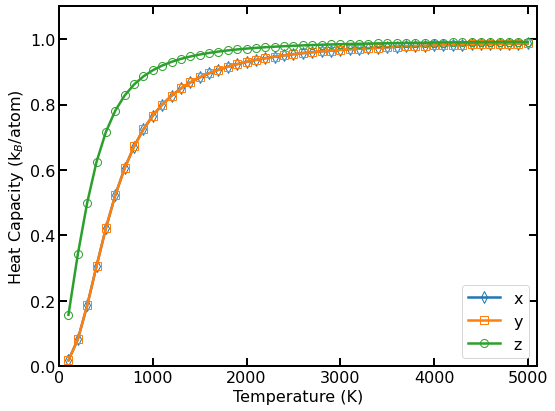

In [12]:
plt.figure(figsize=(8,6))
set_fig_properties(plt.gca())
mew, ms, mfc, lw = 1, 8, 'none', 2.5
plt.plot(temperatures, Cx, lw=lw,marker='d',mfc=mfc,ms=ms,mew=mew)
plt.plot(temperatures, Cy, lw=lw,marker='s',mfc=mfc,ms=ms,mew=mew)
plt.plot(temperatures, Cz, lw=lw,marker='o',mfc=mfc,ms=ms,mew=mew)
plt.xlim([0,5100])
plt.gca().set_xticks(range(0,5001,1000))
plt.ylim([0, 1.1])
plt.gca().set_yticks(np.linspace(0,1,6))
plt.ylabel(r'Heat Capacity (k$_B$/atom)')
plt.xlabel('Temperature (K)')
plt.legend(['x','y','z'])

plt.tight_layout()
plt.show()

Quantum heat capacity per atom as a function of temperature.

 - The above figure shows the calculated per-atom quantum heat capacity in different directions.

 - Again, the in-plane ($x$ and $y$ directions) and out-of-plane ($z$ direction) phonons behave differently.

 - For every direction, the quantum heat capacity increases from 0 to $k_{\rm B}$ with increasing temperature.

 - One can also calculate the Debye temperature as a function of temperature $\Theta(T)$, but we leave it to the reader.

## 4. References
- [Dickey 1969] J. M. Dickey and A. Paskin, [Computer Simulation of the Lattice Dynamics of Solids](https://doi.org/10.1103/PhysRev.188.1407), Phys. Rev. **188**, 1407 (1969).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B **39**, 5566(R) (1989).